# Azure AI Vision SDK `READ` API

In [1]:
import os
# for notebook
import  matplotlib.pyplot as plt
# azure
from azure.ai.vision.imageanalysis import ImageAnalysisClient
from azure.ai.vision.imageanalysis.models import VisualFeatures
from azure.core.credentials import AzureKeyCredential
from dotenv import load_dotenv
# cv
import cv2

In [2]:
# env
load_dotenv()
endpoint = os.getenv("VISION_ENDPOINT")
key = os.getenv("VISION_KEY")
path = "./imgs/sample.jpg"
path_2 = "./imgs/GOOGLE OCR TEST.png"
img_path = "./imgs/sample.jpg"
url_path = ""

In [3]:
class VisionFunctions:
    """
    init params:
        vision resource key
        vision endpoint
    func params:
        ocr_path: path to image
        ocr_url: url to image
    """

    def __init__(self, endpoint, key) -> None:
        self.client = ImageAnalysisClient(
            endpoint=endpoint, credential=AzureKeyCredential(key)
        )

    def ocr_path(self, img_path):
        client = self.client

        with open(img_path, "rb") as file:
            image = file.read()
        
        result = client.analyze(
            image,
            visual_features=[VisualFeatures.READ]
        )

        return result
    
    def ocr_url(self, img_url):
        client = self.client
        
        result = client.analyze_from_url(
            image_url=img_url,
            visual_features=[VisualFeatures.READ]
        )

        return result


Function to extract bounding box and color values


In [4]:
def extract_bounding_boxes(result):
    bounding_boxes = []
    blocks = result['readResult']['blocks']
    for block in blocks:
        for line in block['lines']:
            # Extract line bounding polygon
            line_polygon = [(p['x'], p['y']) for p in line['boundingPolygon']]
            bounding_boxes.append((line_polygon, (0, 255, 0)))  # Green for lines
            for word in line['words']:
                # Extract word bounding polygon
                word_polygon = [(p['x'], p['y']) for p in word['boundingPolygon']]
                bounding_boxes.append((word_polygon, (255, 0, 0)))  # Blue for words
    return bounding_boxes   

Structure of response to get the necesary values

In [5]:
vision_test = VisionFunctions(endpoint, key)
result_test = vision_test.ocr_path(img_path)

index = 0

# coordinates for lines polygon
line_polygon = result_test['readResult']['blocks'][index]['lines'][index]['boundingPolygon'][index].values()

# coordinates for word polygon
word_polygon = result_test['readResult']['blocks'][index]['lines'][index]['words'][index]['boundingPolygon'][0].values()

print(f"Line polygon: {line_polygon}\nWord polygon: {word_polygon}")

Line polygon: dict_values([721, 502])
Word polygon: dict_values([722, 503])


We are creating this structure to later draw


In [6]:
structure = extract_bounding_boxes(result_test)
structure
# list[
# tuple(list[coordinates], tuple[color]),
# ]

[([(721, 502), (843, 502), (843, 519), (721, 519)], (0, 255, 0)),
 ([(722, 503), (785, 503), (785, 520), (722, 520)], (255, 0, 0)),
 ([(800, 503), (842, 502), (842, 519), (800, 520)], (255, 0, 0)),
 ([(720, 525), (819, 526), (819, 544), (720, 543)], (0, 255, 0)),
 ([(721, 526), (759, 526), (759, 544), (721, 543)], (255, 0, 0)),
 ([(765, 526), (819, 527), (819, 545), (765, 544)], (255, 0, 0)),
 ([(721, 548), (791, 548), (791, 563), (721, 564)], (0, 255, 0)),
 ([(723, 548), (750, 548), (750, 564), (723, 564)], (255, 0, 0)),
 ([(761, 548), (788, 549), (787, 564), (760, 564)], (255, 0, 0))]

Function to draw the lines on to the image

In [7]:
def draw_bounding_boxes(image, bounding_boxes, line_width=2):
    # load image
    image = cv2.imread(image)
    # apply boxes
    for polygon, color in bounding_boxes: # for each tuple containing coordinates: list[tuple], color: tuple
        points = [(int(x), int(y)) for x, y in polygon] # extract the coordinates: list[tuple]
        for i in range(len(points)): # draw lines from first point to the next one closing one to the beginning
            start_point = points[i]
            end_point = points[(i + 1) % len(points)]
            cv2.line(image, start_point, end_point, color, line_width)
    return image

In [8]:
# print first 4 polygones to ilustrate
stop = 4
counter = 0
for polygon, color in structure:
    print(f"Polygon number: {counter+1}")
    points = [(int(x), int(y)) for x, y in polygon]
    for i in range(len(points)):
        print(f"line numer: {i + 1}")
        print("start")
        print(points[i])
        print("end")
        print(points[(i + 1) % len(points)])
        print("\n")
    counter += 1
    if counter == stop:
        break
        

Polygon number: 1
line numer: 1
start
(721, 502)
end
(843, 502)


line numer: 2
start
(843, 502)
end
(843, 519)


line numer: 3
start
(843, 519)
end
(721, 519)


line numer: 4
start
(721, 519)
end
(721, 502)


Polygon number: 2
line numer: 1
start
(722, 503)
end
(785, 503)


line numer: 2
start
(785, 503)
end
(785, 520)


line numer: 3
start
(785, 520)
end
(722, 520)


line numer: 4
start
(722, 520)
end
(722, 503)


Polygon number: 3
line numer: 1
start
(800, 503)
end
(842, 502)


line numer: 2
start
(842, 502)
end
(842, 519)


line numer: 3
start
(842, 519)
end
(800, 520)


line numer: 4
start
(800, 520)
end
(800, 503)


Polygon number: 4
line numer: 1
start
(720, 525)
end
(819, 526)


line numer: 2
start
(819, 526)
end
(819, 544)


line numer: 3
start
(819, 544)
end
(720, 543)


line numer: 4
start
(720, 543)
end
(720, 525)




_spanish enabled_

Como se puede ver en el ouput se dibujan 4 lines por cada poligono agarrando el index 0 y index + 1 %(_resto de division entera_) cantidad total de puntos. Esto nos asegura que no tenemos index out of range y que el ultimo punto sea el primero para asi cerrar el poligono.

```py
    i = 0: (0 + 1) % 4 == 1
    i = 1: (1 + 1) % 4 == 2
    i = 2: (2 + 1) % 4 == 3
    i = 3: (3 + 1) % 4 == 0
```
Asi se puede ver mejor como se mueven los index, esto sirve para poligonos de `n` lados
    

## Testing

In [9]:
vision = VisionFunctions(endpoint, key)
result = vision.ocr_path(img_path)

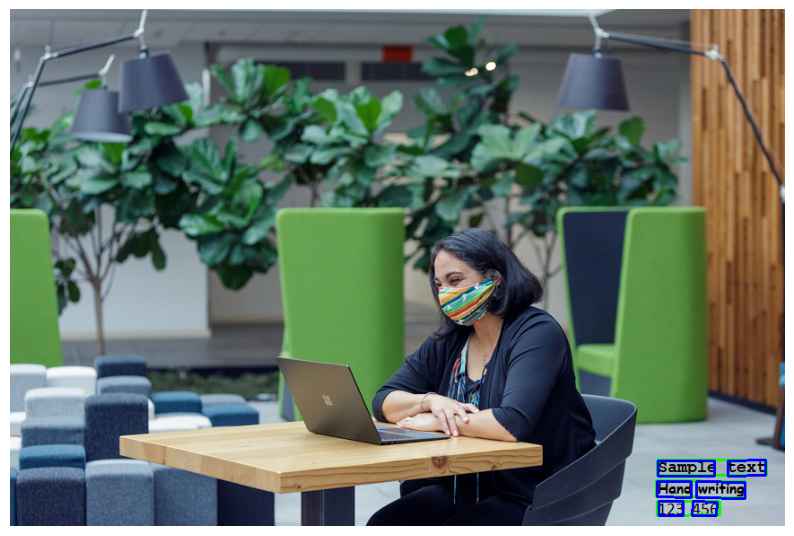

In [10]:
# Extract bounding boxes
bounding_boxes = extract_bounding_boxes(result)

# Draw boxes
final_image = draw_bounding_boxes(img_path, bounding_boxes)

### tiling managers no likey
# cv2.imshow('Image with Bounding Boxes', final_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

#  BGR to RGB
final_image_rgb =  cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(final_image_rgb)
plt.axis('off')  # Hide the axes
plt.show()
# Save the image with bounding boxes
# output_path = 'output_image.jpg'
# cv2.imwrite(output_path, final_image)


One more test

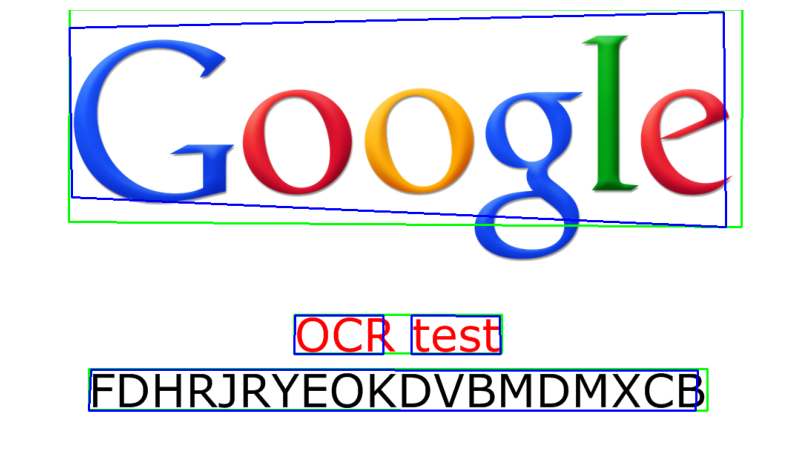

In [11]:
def print_image(img_path):
    result = vision.ocr_path(img_path)
    bounding_boxes = extract_bounding_boxes(result)
    final_image = draw_bounding_boxes(img_path, bounding_boxes)
    final_image_rgb =  cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(final_image_rgb)
    plt.axis('off')  # Hide the axes
    plt.show()

print_image(path_2)